# Day 8 - Lab 1: Vision-Enabled UI/UX Agents

**Objective:** Use multi-modal vision models to generate a frontend UI from a design image, and then use a second agent to perform an automated design review.

**Estimated Time:** 90 minutes

**Introduction:**
Welcome to Day 8! Today, we'll explore one of the most exciting advancements in AI: vision. We will use a vision-capable model to act as a frontend developer, translating a design image directly into code. Then, we will create a second "UI/UX Critic" agent to automate the design review process, demonstrating a complete, AI-assisted frontend workflow.

For definitions of key terms used in this lab, please refer to the [GLOSSARY.md](../../GLOSSARY.md).

## Step 1: Setup

For this lab, we need to ensure we are using a vision-capable model. We will configure our `utils.py` helper to use a model like OpenAI's `gpt-4o` or Google's `gemini-2.5-pro`.

**Model Selection:**
This lab requires a vision-capable model. Excellent choices include `gpt-4o`, `gemini-2.5-pro`, or `deepseek-ai/DeepSeek-VL2`.

**Helper Functions Used:**
- `setup_llm_client()`: To configure the API client.
- `get_vision_completion()`: A specialized function to send an image and a text prompt to a vision model.
- `get_completion()`: To send text-only prompts for the refactoring step.
- `save_artifact()`: To save the generated code and the design review.

In [1]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, save_artifact, clean_llm_output, recommended_models_table
from IPython.display import Image, display, Code

image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image-preview")
print(f"✅ Using {image_model_name} for image generation")

# Ensure you select a vision-capable model
vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="gemini-2.5-pro")
print(f"✅ Using {vision_model_name} for vision tasks")


if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

2025-11-03 13:40:04,330 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image-preview latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image-preview for image generation


2025-11-03 13:40:05,285 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-pro latency_ms=None artifacts_path=None


✅ Using gemini-2.5-pro for vision tasks


In [2]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.0-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.0-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |\n| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |\n| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ |

## Step 2: The Design Screenshot

This is the design we want our AI agent to build. It's a simple login form component. We will provide the URL to this image directly to the model.

STEP 1: Generating Detailed Screen Description

✅ Generated description:

Of course. As a UI/UX design expert, I will create a detailed description for the WelcomePath homepage, designed specifically for a new hire like Alex Chen. This description is optimized for an AI image generator to produce a high-fidelity mockup.

Here is the detailed breakdown of the design choices, followed by the final, single-paragraph description for the image generator.

---

### **Detailed Design Rationale (UI/UX Expert Breakdown)**

1.  **Layout Structure:**
    *   **Header:** A clean, fixed header provides consistent navigation and branding without being intrusive. It establishes trust and a sense of place.
    *   **Hero Section:** This is the most critical area for setting a welcoming tone. A personalized greeting immediately makes the user feel seen and valued, directly addressing the "anxiety" of a new hire.
    *   **Main Content Area:** A card-based layout is used for clarity and scannability. Th


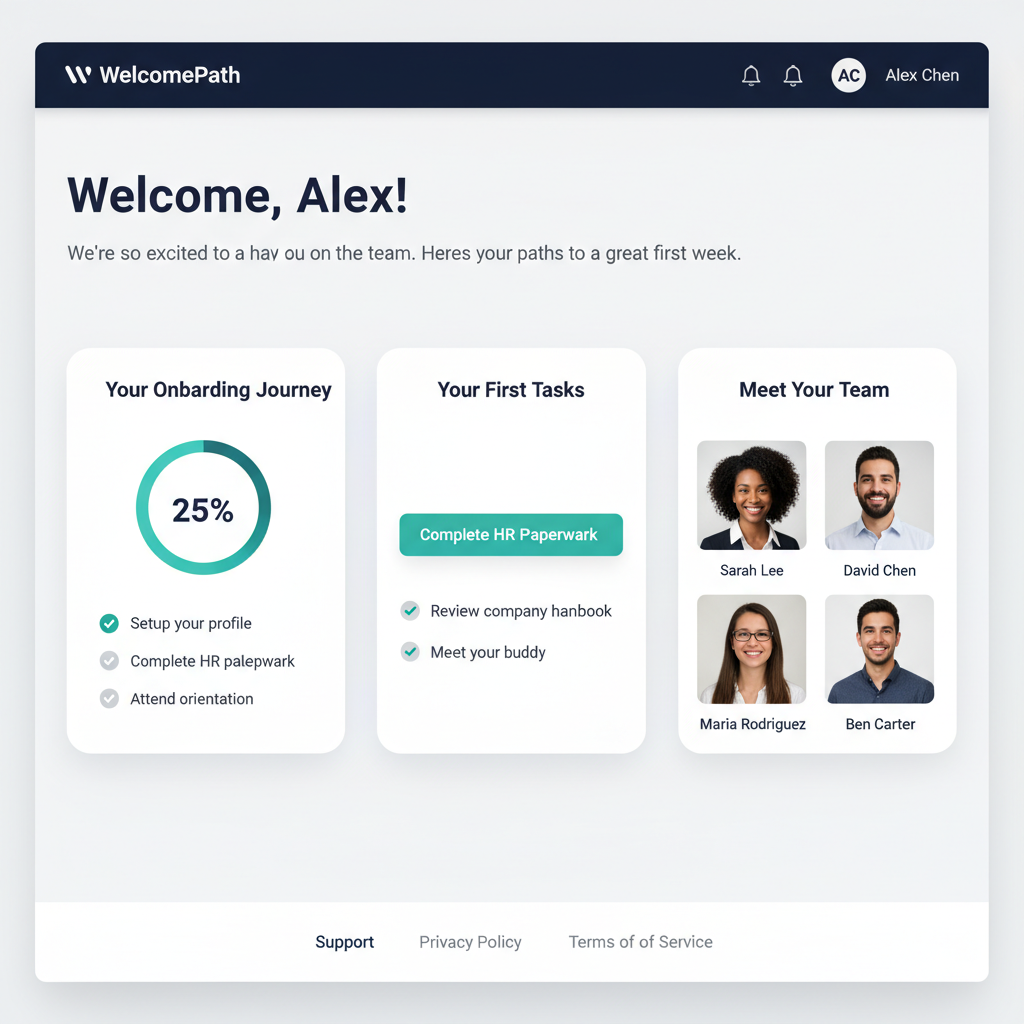


💡 Note: This image will be used in the next challenges for component generation and design review.


In [3]:
from utils import load_artifact

prd_content = load_artifact("artifacts/day1_prd.md")

# Step 1: Use LLM to describe the screen with proper context
screen_description_prompt = f"""
You are an expert UI/UX designer working on an employee onboarding tool. 
Create a detailed description for a homepage screen design that will be used to generate an image.

**Project Context:**
{prd_content}

**Design Requirements:**
- Enterprise employee onboarding application
- Target users: New employees on their first day
- Purpose: Welcome screen that serves as the main entry point
- Design style: Modern, professional, warm and welcoming

Please provide a comprehensive design description including:
1. Layout structure (header, hero section, main content areas, footer)
2. Key UI elements (logo placement, welcome message, navigation menu, call-to-action buttons)
3. Color scheme (professional corporate colors with welcoming accents)
4. Typography hierarchy (headings, body text, emphasis)
5. Visual elements (icons, illustrations, imagery that conveys onboarding/growth)
6. Spacing and whitespace considerations
7. Interactive elements (buttons, cards, links)

Output a single paragraph description optimized for image generation, focusing on visual elements, layout, and style.
"""

print("=" * 80)
print("STEP 1: Generating Detailed Screen Description")
print("=" * 80)

detailed_description = get_completion(screen_description_prompt, vision_client, vision_model_name, vision_api_provider)
print(f"\n✅ Generated description:\n")
print(detailed_description)
print("\n" + "=" * 80)

# Step 2: Use the LLM-generated description for image generation
screen_generation_prompt = f"""
Create a high-fidelity UI mockup based on this description:

{detailed_description}

Style requirements:
- Modern, clean interface design
- Professional corporate aesthetic with warm, welcoming touches
- Clear visual hierarchy
- Generous whitespace
- Accessible color contrast
- Desktop/web application layout (1920x1080 aspect ratio)
"""

print("STEP 2: Generating Screen Design Image")
print("=" * 80)
print(f"Using {image_model_name} for image generation...\n")

file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)

# Step 3: Display the generated image
print("\n" + "=" * 80)
print("STEP 3: Displaying Generated Image")
print("=" * 80)

if file_path and image_url:
    print(f"✅ Image saved to: {file_path}\n")
    display(Image(url=image_url))
    print("\n💡 Note: This image will be used in the next challenges for component generation and design review.")
elif image_url:
    print(f"❌ Image generation failed: {image_url}")
else:
    print("❌ Image generation returned no result")


In [4]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.0-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.0-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |\n| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |\n| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ |

In [5]:
# login_form_url = "https://i.imgur.com/s42SYz6.png"
# display(Image(url=login_form_url))

## Step 3: The Challenges

### Challenge 3.1.1 (Foundational): Generating a Monolithic UI Component

**Task:** Use the vision model to generate a single, self-contained React component that replicates the design from the image.

> **Tip for Vision Prompts:** Be specific about the output format. Telling the model you want 'React' and 'Tailwind CSS' is crucial. The more specific your technical constraints, the better the generated code will be.

**Instructions:**
1.  Create a prompt that asks the vision model to act as an expert frontend developer.
2.  The prompt should instruct the model to analyze the image at the provided URL.
3.  Ask it to generate a single React component using Tailwind CSS for styling.
4.  The output should be a single block of JSX code.

**Expected Quality:** A single file's worth of React code that, when rendered, visually approximates the login form in the screenshot.

In [4]:
# Challenge 3.1.1: Analyze the Generated Design Image
# This cell examines the design and provides a detailed explanation that will guide component generation
image_path = "C:/Users/labadmin/Documents/AG-AISOFTDEV/artifacts/screens/image_1762183106.png"

explain_image_prompt = f"""
You are an expert UI/UX designer and frontend architect analyzing a design mockup.

Your task is to provide a comprehensive design analysis of the provided image that will guide a React developer in implementing the UI.

Please analyze and document the following aspects:

1. **Overall Layout Structure**:
   - Describe the main layout sections (header, hero, content areas, footer)
   - Identify the grid/flex structure and alignment
   - Note any containers, wrappers, or layout groupings

2. **Visual Elements Inventory**:
   - List all UI components (navigation, buttons, cards, forms, images, icons)
   - Describe their positions and relationships
   - Note any groupings or visual hierarchies

3. **Color Palette**:
   - Identify all colors used (backgrounds, text, accents, borders)
   - Map them to approximate Tailwind CSS color classes (e.g., bg-blue-500, text-gray-700)
   - Note any gradients or color transitions

4. **Typography Details**:
   - Identify heading levels and their styles (size, weight, color)
   - Note body text styles and any emphasis
   - Suggest appropriate Tailwind text classes

5. **Spacing & Sizing**:
   - Describe padding and margins (approximate Tailwind scale: p-4, m-8, gap-6, etc.)
   - Note element sizes and dimensions
   - Identify consistent spacing patterns

6. **Interactive Elements**:
   - List all buttons, links, and interactive components
   - Describe their visual states (default, hover, active)
   - Note any form inputs or controls

7. **Component Naming Suggestion**:
   - Suggest an appropriate name for the main component
   - Identify what type of screen/page this represents

Provide your analysis in markdown format with clear sections. Be specific about Tailwind CSS classes that would work well for this design.
"""

print("--- Challenge 1 - Step 1: Analyzing Design Image ---")
if vision_model_name:
    design_analysis = get_vision_completion(explain_image_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_analysis = clean_llm_output(design_analysis, language="markdown")
    display(Code(cleaned_analysis, language="markdown"))
    # Save the design analysis for reference
    save_artifact(cleaned_analysis, "artifacts/design_analysis.md", overwrite = True)
    print(f"\n✅ Design analysis saved to: artifacts/design_analysis.md")
else:
    print("Skipping design analysis because no vision model is configured.")
    design_analysis = ""



--- Challenge 1 - Step 1: Analyzing Design Image ---


/components
  /layout
    Header.jsx
    Footer.jsx (if any)
  /dashboard
    WelcomeHero.jsx
    ActionCard.jsx  // The reusable card component
    ActionGrid.jsx  // The grid container for the cards
/pages
  OnboardingDashboard.jsx // The main page component assembling the above


✅ Design analysis saved to: artifacts/design_analysis.md


In [5]:
# Challenge 3.1.2: Generate the Monolithic React Component
# This cell generates the actual React code based on the design image
generate_ui_prompt = f"""
You are an expert frontend developer specializing in React and Tailwind CSS.

Your task: Analyze the provided design image and generate a single, self-contained React component that replicates the design.

**Technical Requirements:**
- Framework: React (functional component with hooks if state is needed)
- Styling: Tailwind CSS utility classes ONLY (no custom CSS, no inline styles)
- Output: Complete, runnable JSX code in a single file
- Structure: ONE monolithic component (do NOT break into sub-components)

**Implementation Instructions:**

1. **Analyze the Image**: Carefully examine every visual element:
   - Layout structure and positioning
   - Colors, gradients, shadows
   - Typography (sizes, weights, colors)
   - Spacing and alignment
   - Interactive elements (buttons, links, inputs)
   - Icons and images

2. **Component Structure**:
   - Create a functional React component
   - Include necessary imports: `import React from 'react';` (and useState/useEffect if needed)
   - Name the component appropriately based on what you see
   - Export as default: `export default ComponentName;`

3. **HTML Structure**:
   - Use semantic HTML5 elements (header, nav, main, section, footer, button, etc.)
   - Add aria-labels for accessibility
   - Ensure proper heading hierarchy (h1, h2, h3)

4. **Tailwind CSS Styling**:
   - Use Tailwind utility classes for ALL styling
   - Match colors precisely (bg-blue-500, text-gray-700, etc.)
   - Apply appropriate spacing (p-4, m-6, gap-4, space-y-2)
   - Add responsive classes where appropriate (md:, lg:)
   - Include hover/focus states (hover:bg-blue-600, focus:ring-2)

5. **Interactive Elements**:
   - Include all buttons, links, and form elements from the image
   - Add onClick handlers (can be empty: `onClick={{() => {{}}}}`)
   - For forms: use proper input types and labels

6. **Code Quality**:
   - Add comments for major sections (// Header, // Hero Section, // Footer)
   - Use clear, descriptive variable names
   - Format code with proper indentation

7. **Content**:
   - Use the exact text visible in the image
   - Add placeholder text where appropriate
   - Use emoji or text labels if icons aren't clearly defined

**Output Format:**
Provide ONLY the complete React component code. Start with imports, then the component definition, and end with export.

Do NOT include:
- Markdown code fences (```)
- Explanations or commentary outside the code
- Multiple files or separate components

The code should be ready to copy directly into a .jsx file and run.
"""
print("--- Challenge 1 - Step 2: Generating Monolithic React Component ---")
if vision_model_name:
    generated_monolithic_code = get_vision_completion(generate_ui_prompt, file_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_code = clean_llm_output(generated_monolithic_code, language='jsx')
    display(Code(cleaned_code, language='jsx'))
    # Save the generated monolithic component
    save_artifact(cleaned_code, "artifacts/monolithic_component.jsx", overwrite=True)
    print(f"\n✅ Monolithic component saved to: artifacts/monolithic_component.jsx")
else:
    print("Skipping UI generation because no valid model is configured.")
    cleaned_code = ""

--- Challenge 1 - Step 2: Generating Monolithic React Component ---


import React from 'react';

// SVG Icon components defined within the main component file to keep it self-contained.

const LogoWIcon = () => (
  <div className="bg-white w-8 h-8 rounded-md flex items-center justify-center">
    <svg width="20" height="14" viewBox="0 0 20 14" fill="none" xmlns="http://www.w3.org/2000/svg">
      <path d="M2.144 0.463998L0 13.252L6.016 13.204L7.096 7.492L9.88 13.156L12.928 2.236L14.936 13.156L20 13.06L17.856 0.315998L13.96 0.363998L11.512 9.556L8.872 0.411998L2.144 0.463998Z" fill="#1E293B"/>
    </svg>
  </div>
);

const BellIcon = () => (
  <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6 text-gray-300 hover:text-white" fill="none" viewBox="0 0 24 24" stroke="currentColor">
    <path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M15 17h5l-1.405-1.405A2.032 2.032 0 0118 14.158V11a6.002 6.002 0 00-4-5.659V5a2 2 0 10-4 0v.341C7.67 6.165 6 8.388 6 11v3.159c0 .538-.214 1.055-.595 1.436L4 17h5m6 0v1a3 3 0 11-6 0v-1m6 0H9" />
  </svg>
);

const CompletedCheckIcon = () => (
  <svg className="w-6 h-6" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
    <circle cx="12" cy="12" r="12" fill="#2DD4BF"/>
    <path d="M17.2738 8.52628L10.3798 15.4203L7.22754 12.268" stroke="white" strokeWidth="2" strokeLinecap="round" strokeLinejoin="round"/>
  </svg>
);

const IncompleteCheckIcon = () => (
  <svg className="w-6 h-6" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
    <circle cx="12" cy="12" r="11.5" fill="white" stroke="#E5E7EB"/>
    <path d="M17.2738 8.52628L10.3798 15.4203L7.22754 12.268" stroke="#D1D5DB" strokeWidth="2" strokeLinecap="round" strokeLinejoin="round"/>
  </svg>
);


const OnboardingDashboard = () => {
  return (
    <div className="bg-gray-100 min-h-screen font-sans">
      {/* Header */}
      <header className="bg-slate-800 shadow-md">
        <nav className="max-w-7xl mx-auto px-4 sm:px-6 lg:px-8">
          <div className="flex items-center justify-between h-16">
            <div className="flex items-center">
              <div className="flex-shrink-0 flex items-center gap-3">
                <LogoWIcon />
                <span className="text-white text-xl font-semibold">WelcomePath</span>
              </div>
            </div>
            <div className="flex items-center gap-5">
              <button aria-label="Notifications">
                <BellIcon />
              </button>
              <button aria-label="Messages">
                <BellIcon />
              </button>
              <div className="flex items-center gap-3">
                <div className="w-9 h-9 rounded-full bg-gray-200 flex items-center justify-center">
                  <span className="font-bold text-slate-700">AC</span>
                </div>
                <span className="text-white font-medium hidden sm:block">Alex Chen</span>
              </div>
            </div>
          </div>
        </nav>
      </header>

      {/* Main Content */}
      <main className="p-4 sm:p-6 lg:p-10">
        <div className="max-w-6xl mx-auto">
          {/* Welcome Message */}
          <section className="mb-10">
            <h1 className="text-4xl font-bold text-slate-800">Welcome, Alex!</h1>
            <p className="mt-2 text-lg text-slate-500">
              We're so excited to a hav ou on the team. Heres your paths to a great first week.
            </p>
          </section>

          {/* Cards Section */}
          <section className="grid grid-cols-1 md:grid-cols-2 lg:grid-cols-3 gap-8">
            
            {/* Card 1: Your Onboarding Journey */}
            <div className="bg-white rounded-2xl shadow-lg p-6 flex flex-col">
              <h2 className="text-xl font-bold text-slate-800 mb-4">Your Onbarding Journey</h2>
              <div className="flex-grow flex flex-col items-center justify-center my-4">
                <div className="relative w-40 h-40">
                  <svg className="w-full h-full" viewBox="0 0 100 100">
    


✅ Monolithic component saved to: artifacts/monolithic_component.jsx


### Challenge 3.2 (Intermediate): Refactoring into Reusable Components

**Task:** A single, large component is not good practice. Now, prompt the LLM to refactor the monolithic code it just generated into smaller, reusable sub-components.

**Instructions:**
1.  Create a new prompt.
2.  Provide the monolithic JSX code from the previous step as context.
3.  Instruct the LLM to act as a senior frontend developer who champions clean code.
4.  Ask it to refactor the code by creating smaller, reusable components (e.g., `<StyledButton>`, `<InputWithIcon>`).
5.  The final output should be the complete code with the new, smaller components defined and used within the main `Login` component.

**Expected Quality:** A well-structured React file that demonstrates the component-based architecture, which is a fundamental best practice in modern frontend development.

In [6]:
# Challenge 2: Refactor the monolithic code into smaller, reusable components
refactor_ui_prompt = f"""
You are a senior frontend developer who champions clean, maintainable code and component-based architecture.

Your task is to refactor the following monolithic React component into smaller, reusable sub-components following React best practices.

**Current Monolithic Code:**
```jsx
{cleaned_code}
```

**Refactoring Requirements:**

1. **Identify Reusable Patterns**: Analyze the code and identify UI elements that appear multiple times or could be reused:
   - Buttons (primary, secondary, outlined, etc.)
   - Input fields (text inputs, with/without icons, with labels)
   - Cards or containers
   - Navigation items
   - Form groups
   - Any repeated visual patterns

2. **Create Sub-Components**: Extract these patterns into separate, reusable components:
   - Name components descriptively (e.g., `Button`, `InputField`, `Card`, `NavLink`)
   - Each component should accept props for customization
   - Components should be self-contained and reusable

3. **Component Structure**: Organize the refactored code as follows:
   - Define all sub-components first (at the top of the file, after imports)
   - Then define the main parent component that uses these sub-components
   - Maintain the same visual output as the original monolithic component

4. **Props and Customization**: Each sub-component should:
   - Accept relevant props (text, onClick, className, type, placeholder, etc.)
   - Allow for style customization through props when appropriate
   - Use sensible default values where applicable

5. **Code Quality**:
   - Add clear comments for each component explaining its purpose
   - Use destructuring for props
   - Maintain consistent naming conventions
   - Keep Tailwind CSS utility classes
   - Ensure accessibility attributes are preserved

6. **Component Examples** (create similar sub-components as appropriate):
   - `Button`: Reusable button with variants (primary, secondary, size options)
   - `InputField`: Form input with optional icon, label, and error state
   - `Card`: Container component for grouped content
   - `NavItem`: Navigation link or menu item

**Output Format:**
Provide ONLY the complete refactored code in a single file. The structure should be:
1. Import statements
2. All sub-component definitions (with comments)
3. Main parent component using the sub-components
4. Export statement

Do NOT include:
- Markdown code fences (```)
- Explanations outside the code
- Multiple separate files

The refactored code should be production-ready and demonstrate clean component-based architecture.
"""

print("--- Challenge 2: Refactoring UI into Reusable Components ---")

# Initialize the variable first
cleaned_refactored_code = ""

if 'cleaned_code' in dir() and cleaned_code:
    print(f"📝 Refactoring {len(cleaned_code)} characters of monolithic code...")
    refactored_code = get_completion(refactor_ui_prompt, vision_client, vision_model_name, vision_api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    display(Code(cleaned_refactored_code, language='jsx'))
    # Save the refactored component
    save_artifact(cleaned_refactored_code, "artifacts/refactored_component.jsx", overwrite=True)
    print(f"\n✅ Refactored component saved to: artifacts/refactored_component.jsx")
    print(f"✅ Variable 'cleaned_refactored_code' is now set ({len(cleaned_refactored_code)} characters)")
else:
    print("⚠️ Skipping refactoring because monolithic code was not generated.")
    print("   → You need to run Challenge 3.1.2 first to generate the monolithic component")
    print(f"   → Current cleaned_code status: {'exists but empty' if 'cleaned_code' in dir() else 'does not exist'}")

--- Challenge 2: Refactoring UI into Reusable Components ---
📝 Refactoring 9520 characters of monolithic code...


import React from 'react';

// ================================================================================================
// 1. ICON COMPONENTS
// ================================================================================================
// Note: In a real-world application, these would likely be in a dedicated `components/icons` directory.

/**
 * The main application logo icon.
 */
const LogoWIcon = () => (
  <div className="bg-white w-8 h-8 rounded-md flex items-center justify-center">
    <svg width="20" height="14" viewBox="0 0 20 14" fill="none" xmlns="http://www.w3.org/2000/svg">
      <path d="M2.144 0.463998L0 13.252L6.016 13.204L7.096 7.492L9.88 13.156L12.928 2.236L14.936 13.156L20 13.06L17.856 0.315998L13.96 0.363998L11.512 9.556L8.872 0.411998L2.144 0.463998Z" fill="#1E293B"/>
    </svg>
  </div>
);

/**
 * A notification bell icon.
 */
const BellIcon = () => (
  <svg xmlns="http://www.w3.org/2000/svg" className="h-6 w-6 text-gray-300 hover:text-white" fill="none" viewBox="0 0 24 24" stroke="currentColor">
    <path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M15 17h5l-1.405-1.405A2.032 2.032 0 0118 14.158V11a6.002 6.002 0 00-4-5.659V5a2 2 0 10-4 0v.341C7.67 6.165 6 8.388 6 11v3.159c0 .538-.214 1.055-.595 1.436L4 17h5m6 0v1a3 3 0 11-6 0v-1m6 0H9" />
  </svg>
);

/**
 * A checkmark icon for completed tasks.
 */
const CompletedCheckIcon = () => (
  <svg className="w-6 h-6" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
    <circle cx="12" cy="12" r="12" fill="#2DD4BF"/>
    <path d="M17.2738 8.52628L10.3798 15.4203L7.22754 12.268" stroke="white" strokeWidth="2" strokeLinecap="round" strokeLinejoin="round"/>
  </svg>
);

/**
 * An empty check circle for incomplete tasks.
 */
const IncompleteCheckIcon = () => (
  <svg className="w-6 h-6" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
    <circle cx="12" cy="12" r="11.5" fill="white" stroke="#E5E7EB"/>
    <path d="M17.2738 8.52628L10.3798 15.4203L7.22754 12.268" stroke="#D1D5DB" strokeWidth="2" strokeLinecap="round" strokeLinejoin="round"/>
  </svg>
);

// ================================================================================================
// 2. ATOMIC & REUSABLE UI COMPONENTS
// ================================================================================================

/**
 * A generic card component with a title and content area.
 * @param {string} title - The title of the card.
 * @param {React.ReactNode} children - The content to be rendered inside the card.
 * @param {string} [className] - Optional additional CSS classes.
 */
const Card = ({ title, children, className = '' }) => (
  <div className={`bg-white rounded-2xl shadow-lg p-6 flex flex-col ${className}`}>
    <h2 className="text-xl font-bold text-slate-800 mb-4">{title}</h2>
    <div className="flex-grow">
      {children}
    </div>
  </div>
);

/**
 * A reusable button component.
 * @param {React.ReactNode} children - The button's text or content.
 * @param {function} [onClick] - The function to call when the button is clicked.
 * @param {string} [className] - Optional additional CSS classes.
 */
const Button = ({ children, onClick, className = '' }) => (
  <button
    onClick={onClick}
    className={`w-full bg-teal-400 text-white font-bold py-3 px-6 rounded-lg hover:bg-teal-500 transition duration-300 shadow-md ${className}`}
  >
    {children}
  </button>
);

/**
 * A button that renders an icon, ensuring accessibility.
 * @param {React.ElementType} IconComponent - The icon component to render.
 * @param {string} label - The accessible label for the button.
 */
const IconButton = ({ IconComponent, label }) => (
  <button aria-label={label}>
    <IconComponent />
  </button>
);

/**
 * A checklist item with a completed or incomplete state.
 * @param {boolean} isCompleted - Determines if the checkmark is filled or empty.
 * @param {React.ReactNode} children - The text content of the checklist item.
 */
const Chec


✅ Refactored component saved to: artifacts/refactored_component.jsx
✅ Variable 'cleaned_refactored_code' is now set (12018 characters)


### Challenge 3.3 (Advanced): The AI UI/UX Critic Agent

**Task:** Create a new "UI/UX Critic" agent. This agent will be given both the original design image and the generated code, and its job is to perform an automated design review.

**Instructions:**
1.  Create a final, complex prompt for a new agent.
2.  The prompt should instruct the agent to act as a meticulous UI/UX designer.
3.  Provide the agent with two pieces of context: the URL of the original design image and the final, refactored React code.
4.  The agent's task is to compare the code's likely rendered output to the design image and list any visual inconsistencies in spacing, font size, color, or layout.

**Expected Quality:** A critical design review in markdown format. This demonstrates a powerful AI-on-AI workflow, where one AI generates work and another AI validates it, automating a time-consuming QA step.

In [7]:
# Challenge 3: Create the UI/UX Critic Agent for automated design review
critic_agent_prompt = f"""
You are a meticulous UI/UX designer and design critic with years of experience reviewing frontend implementations for pixel-perfect accuracy and adherence to design specifications.

Your task is to perform a comprehensive design review by comparing the provided design image with the React code implementation below.

**Refactored React Code to Review:**
```jsx
{cleaned_refactored_code}
```

**Review Instructions:**

1. **Visual Comparison**: Carefully examine the design image and mentally render what the provided React code would produce. Compare the two side-by-side.

2. **Analysis Areas**: Evaluate the following aspects and identify ANY discrepancies, no matter how small:

   **Layout & Structure**:
   - Overall page/component layout and sections
   - Grid/flexbox alignment and positioning
   - Element grouping and hierarchy
   - Responsive breakpoints (if applicable)

   **Spacing & Dimensions**:
   - Padding within elements (compare to Tailwind classes used)
   - Margins between elements
   - Gap spacing in flex/grid layouts
   - Element widths, heights, and sizes
   - Border radius values

   **Typography**:
   - Font sizes (compare actual vs. Tailwind text-* classes)
   - Font weights (light, regular, medium, bold, etc.)
   - Line heights and letter spacing
   - Text colors and contrast
   - Heading hierarchy (h1, h2, h3, etc.)

   **Colors**:
   - Background colors (exact hex codes vs. Tailwind approximations)
   - Text colors
   - Border colors
   - Accent and highlight colors
   - Gradients (if present)
   - Shadow colors and opacity

   **Visual Effects**:
   - Box shadows (size, blur, spread, color)
   - Border styles and widths
   - Opacity and transparency
   - Hover and focus states

   **Interactive Elements**:
   - Button styles and variants
   - Input field styling
   - Icon placement and sizing
   - Link appearances

   **Content Accuracy**:
   - Text content matching
   - Icon usage and placement
   - Image positioning

3. **Output Format**: Provide your review as a structured markdown document with the following sections:

   **## Design Review Summary**
   Brief overview (2-3 sentences) of overall accuracy and major findings.

   **## Critical Issues** (if any)
   List issues that significantly impact visual fidelity or user experience.

   **## Minor Inconsistencies** (if any)
   List small discrepancies that could be improved.

   **## Positive Observations**
   Highlight what was implemented well and matches the design accurately.

   **## Recommendations**
   Specific, actionable suggestions for improving the implementation (with code examples if helpful).

   **## Tailwind CSS Adjustments** (if needed)
   Specific Tailwind class changes to better match the design (e.g., "Change `text-lg` to `text-xl`" or "Replace `p-4` with `p-6`").

4. **Review Guidelines**:
   - Be thorough and detail-oriented
   - Use specific measurements and values when possible
   - Reference Tailwind CSS classes where applicable
   - Be constructive in your criticism
   - Prioritize issues by impact (critical vs. minor)
   - Consider accessibility implications

**Important**: Base your review on what you observe in the design image compared to what the code would likely render. Be specific about discrepancies and provide actionable feedback.
"""

print("--- Challenge 3: Invoking UI/UX Critic Agent for Design Review ---")

# Determine which image path to use (file_path from Step 2, or fallback to image_path from Challenge 3.1.1)
image_to_review = None
if 'file_path' in dir() and file_path:
    image_to_review = file_path
    print(f"📸 Using generated image from Step 2: {file_path}")
elif 'image_path' in dir() and image_path:
    image_to_review = image_path
    print(f"📸 Using fallback image path: {image_path}")
else:
    print("⚠️ ERROR: No image path available!")
    print("   → You need to run Step 2 (Design Screenshot) first")

# Check if we have the refactored code
if not ('cleaned_refactored_code' in dir() and cleaned_refactored_code):
    print("⚠️ ERROR: cleaned_refactored_code is not available!")
    print("   → You need to run Challenge 3.2 (Refactoring) first")
    print("   → Current status:", 'exists but empty' if 'cleaned_refactored_code' in dir() else 'does not exist')
elif not image_to_review:
    print("⚠️ Cannot proceed: No image available for comparison")
else:
    print(f"✅ All prerequisites met. Starting design review...")
    print(f"   - Image: {image_to_review}")
    print(f"   - Code length: {len(cleaned_refactored_code)} characters")
    
    design_review = get_vision_completion(critic_agent_prompt, image_to_review, vision_client, vision_model_name, vision_api_provider)
    
    # For markdown reviews, we want the full response, not cleaned/extracted code blocks
    # The clean_llm_output function might extract code blocks instead of the full markdown
    # So we'll save the raw response and display it
    
    # Try to clean it, but if it looks wrong (too short or starts with code), use raw
    cleaned_review = clean_llm_output(design_review, language='markdown')
    
    # Check if cleaning went wrong (extracted code instead of full review)
    if len(cleaned_review) < 500 or cleaned_review.strip().startswith(('jsx', 'javascript', 'const', 'import', 'function')):
        print("⚠️ Detected incorrect parsing - using raw LLM output instead")
        cleaned_review = design_review
    
    display(Code(cleaned_review, language='markdown'))
    save_artifact(cleaned_review, "artifacts/design_review.md", overwrite=True)
    print(f"\n✅ Design review saved to: artifacts/design_review.md")
    print(f"   Review length: {len(cleaned_review)} characters")

--- Challenge 3: Invoking UI/UX Critic Agent for Design Review ---
📸 Using generated image from Step 2: C:\Users\labadmin\Documents\AG-AISOFTDEV\artifacts\screens\image_1762195896.png
✅ All prerequisites met. Starting design review...
   - Image: C:\Users\labadmin\Documents\AG-AISOFTDEV\artifacts\screens\image_1762195896.png
   - Code length: 12018 characters
⚠️ Detected incorrect parsing - using raw LLM output instead
⚠️ Detected incorrect parsing - using raw LLM output instead


Of course. Here is a meticulous design review comparing the provided image and the React implementation.

***

## Design Review Summary

The React implementation provides a solid functional foundation for the onboarding dashboard and successfully captures the general layout and component structure. However, there are several key visual discrepancies that prevent it from achieving pixel-perfect accuracy. The most critical issue is the fundamental difference in the main content area's layout (a single white container in the design vs. individual floating cards in the code). Other notable deviations include incorrect icon states, typography hierarchy, and subtle but important differences in spacing and visual effects like shadows and border radii.

## Critical Issues

1.  **Main Page Layout Structure:** The most significant deviation is the overall page structure.
    *   **Design:** The entire central content area (Welcome message, three cards, and footer) is enclosed within a single, large, white container with rounded corners, sitting on top of a light gray background.
    *   **Implementation:** The code uses a global `bg-gray-100` for the page and renders the cards as separate white elements floating on this gray background. The footer is also a separate element on the gray background. This fundamentally changes the visual grouping and perceived layout of the page.

2.  **Incomplete Task Icon is Incorrect:** The visual state for an incomplete task is wrong.
    *   **Design:** The icon for an incomplete task is an empty circle with a simple gray border. There is no checkmark inside it.
    *   **Implementation:** The `IncompleteCheckIcon` component contains a `<path>` element for a checkmark, styled with a light gray stroke (`stroke="#D1D5DB"`). This incorrectly implies a "disabled" or pre-filled state rather than an "empty" state.

## Minor Inconsistencies

1.  **Card Corner Radius:** The cards in the design have a more pronounced, softer corner radius.
    *   **Design:** The `border-radius` appears to be larger, likely around `24px`.
    *   **Implementation:** The `Card` component uses `rounded-2xl`, which corresponds to `1rem` (`16px`). This makes the corners look sharper than intended.

2.  **Card Box Shadow:** The shadow effect on the cards is harsher in the implementation.
    *   **Design:** The cards have a very soft, diffuse, and subtle shadow that gives them a gentle lift.
    *   **Implementation:** The `Card` component uses `shadow-lg`. While a good default, it's slightly darker and less spread out than the shadow in the design.

3.  **Card Title Typography:** The card titles' font size breaks the established typographic hierarchy.
    *   **Design:** The card titles ("Your Onboarding Journey", etc.) are smaller than the main page sub-header ("We're so excited..."). They appear to be bold or semi-bold.
    *   **Implementation:** The card title `h2` uses `text-xl` (`1.25rem`), while the page sub-header `<p>` uses `text-lg` (`1.125rem`). This inverts the intended visual hierarchy.

4.  **"Onboarding Journey" Card Layout:** The vertical spacing in the first card is slightly off.
    *   **Design:** There is significant space between the progress circle and the title, and between the circle and the checklist below it.
    *   **Implementation:** The `my-4` (`1rem`) on the progress bar's container might not be enough to match the more generous spacing in the design. The gap between the progress bar and the checklist (`mt-4`) is also tighter.

5.  **Text Content Mismatch:** There are minor typos in the design image that are corrected in the code's mock data. While the code is correct, this is a noted difference.
    *   **Design Image:** "hav ou", "Heres your paths", "Complete HR palepwark".
    *   **Code Data:** "have you", "Here's your path", "Complete HR paperwork".

## Positive Observations

1.  **Excellent Componentization:** The code is cleanly broken down into reusable and logical components (e.g., `Card`, `


✅ Design review saved to: artifacts/design_review.md
   Review length: 7665 characters


## Lab Conclusion

Fantastic! You have completed a full, end-to-end frontend development workflow using multiple AI agents. You used a vision-powered agent to generate code from a design, a refactoring agent to improve the code's structure, and a critic agent to perform an automated design review. This powerful combination of skills can dramatically accelerate the process of turning visual ideas into functional user interfaces.

> **Key Takeaway:** The workflow of **Generate -> Refactor -> Critique** is a powerful AI-assisted development pattern. Using specialized agents for each step allows you to rapidly create a first draft, improve its quality, and then automatically check it for correctness, significantly speeding up the iteration cycle.